In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import *
from qiskit.visualization import plot_histogram

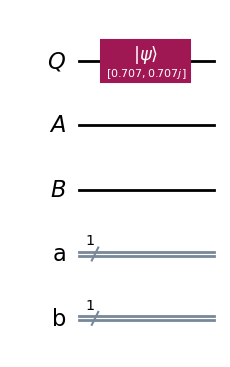

In [2]:

qubit = QuantumRegister(1, "Q")  # Qubit Alice wants to send
ebit0 = QuantumRegister(1, "A")  # entanglet Qubit - part stored by ALice
ebit1 = QuantumRegister(1, "B")  # entanglet Qubit - part stored by Bit (and also a target)
a = ClassicalRegister(1, "a")    # bits for measurement
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)
from math import sqrt
protocol.initialize([0+1/sqrt(2),0+1j/sqrt(2)], 0) #init Q Qubit to some state we want to have
# note that otherwise, quibit is in state 0

protocol.draw()


In [3]:

#sim=AerSimulator()
backend = Aer.get_backend('statevector_simulator') # Simulate the initial state
jobInit0= backend.run(protocol)
resultInit0=jobInit0.result()
outputstate = resultInit0.get_statevector(protocol,decimals=3)
print(outputstate)
# vector corresponds to states BAQ = 000,001,010,011,100,101,110,111
# With our initalization, the qubits are either in state 000 or 001 (not yet entangled B and A, qubit Q either 0 or 1)

Statevector([0.707+0.j   , 0.   +0.707j, 0.   +0.j   , 0.   +0.j   ,
             0.   +0.j   , 0.   +0.j   , 0.   +0.j   , 0.   +0.j   ],
            dims=(2, 2, 2))


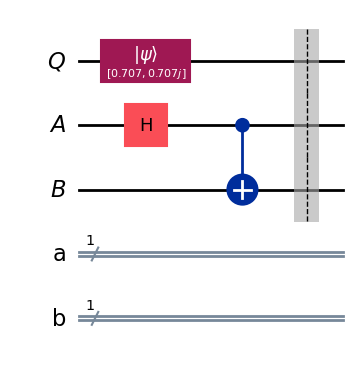

In [4]:
# Prepare ebit used for teleportation
# i.e. ensure the entanglement of qubits B and A
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()
protocol.draw()




In [5]:
#sim=AerSimulator()
backend = Aer.get_backend('statevector_simulator')
jobBefore= backend.run(protocol)
resultBefore=jobBefore.result()
outputstate = resultBefore.get_statevector(protocol,decimals=3)
print(outputstate)
# now Qubits B and A are entangled, i.e. either in state 00 or 11 (1/sqrt(2)|00>+1/sqrt(2)|11>)
# in addition Q is either in 0 or 1 (1/sqrt(2)+j/sqrt(2))
# the states are product of these


Statevector([0.5+0.j , 0. +0.5j, 0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ,
             0.5+0.j , 0. +0.5j],
            dims=(2, 2, 2))


In [6]:
# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'Q'), 0), Qubit(QuantumRegister(1, 'A'), 0), Qubit(QuantumRegister(1, 'B'), 0)), clbits=())

In [7]:
jobAlice= backend.run(protocol)
resultAlice=jobAlice.result()
outputstate = resultAlice.get_statevector(protocol,decimals=3)
print(outputstate)
# in our case all states are equiprobable, in general all values of QA need to have the same probability
# here for our case, hard to interpret the data, do not try now

Statevector([ 0.354+0.j   ,  0.354+0.j   ,  0.   +0.354j, -0.   -0.354j,
              0.   +0.354j, -0.   -0.354j,  0.354+0.j   ,  0.354+0.j   ],
            dims=(2, 2, 2))


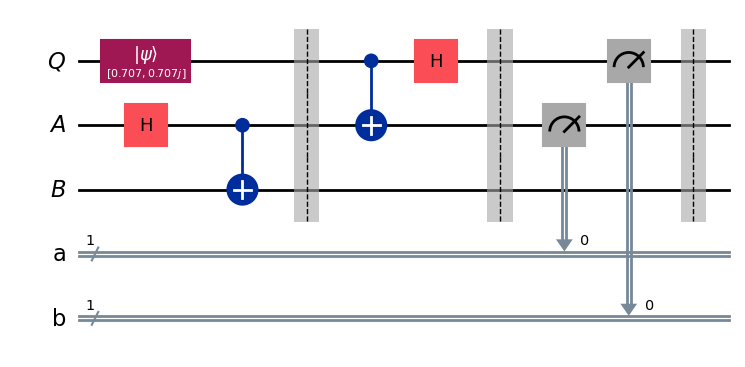

In [8]:

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()
protocol.draw()

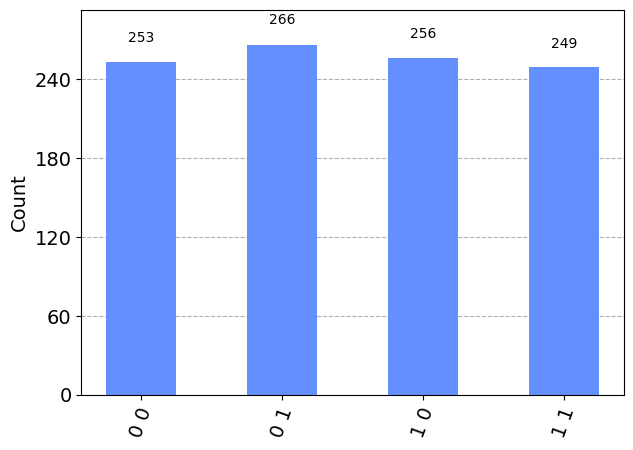

In [9]:
sim=AerSimulator()
jobAlice = sim.run(protocol)      # run the experiment
resultAlice = jobAlice.result()  # get the results
# interpret the results as a "counts" dictionary
countsAlice=resultAlice.get_counts()
plot_histogram(countsAlice)
# all measured values of AQ=ab (00,01,10,11) need to have the same probability


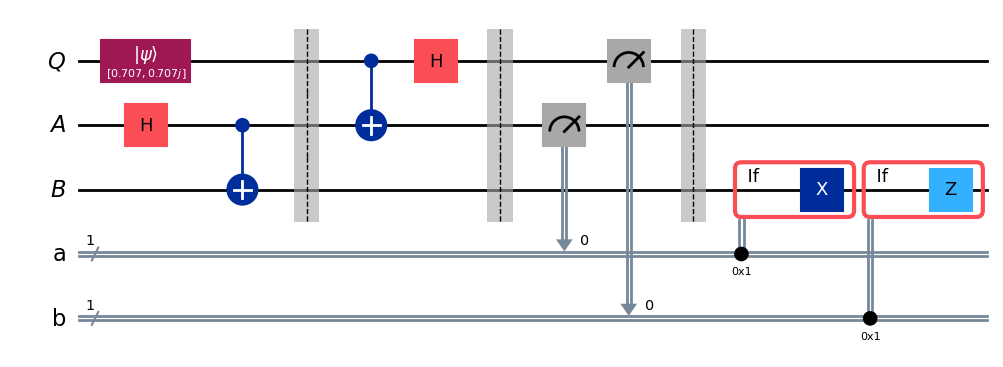

In [10]:
# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw()

In [11]:
jobBob= backend.run(protocol)
resultBob=jobBob.result()
outputstate = resultBob.get_statevector(protocol,decimals=3)
print(outputstate)
# After teleportation, Bob's qubit B will be in the same state as was initially Alices qubit Q
# In our case 0.707 for 0 and 0.707j for 1 at B position

Statevector([ 0.   +0.j   ,  0.707+0.j   ,  0.   +0.j   ,  0.   +0.j   ,
             -0.   +0.j   ,  0.   +0.707j, -0.   +0.j   , -0.   +0.j   ],
            dims=(2, 2, 2))
